## Tracking activity on Companies House

Import all the dependencies.

In [1]:
import os, json
import matplotlib.pyplot as plt
from raphtory import Graph
from raphtory import vis
from datetime import datetime, timedelta

### How to obtain the data

The Companies House data can be obtained via their [REST API](https://developer.company-information.service.gov.uk/overview). For this example to work, you will need to use our Companies House scraper. We have made the scraper accessible [via pip install](https://test.pypi.org/project/cohospider/).  All you will need to do is enter your Companies House REST API key which can be obtained from the website via creating a developer account. Our [blog](https://www.raphtory.com/Companies-House-Tutorial/) explains how to do this, in addition to how you can download and run our scraper via pip install.

### Analysing the data with Raphtory

We use the python json library to parse the json files obtained via the crawler. Through this, we can create a Raphtory graph and add our variables to the graph via the `add_edge` function.

Enter the directory path to your json files inside the path_to_json quotation marks, it should look something like: ~/data/aqWJlHS4_rJSJ7rLgTK49iO4gAg.

In [2]:
path_to_json = '/Users/rachelchan/Documents/companies-house-example-2023-data/barbara_kahan/aqWJlHS4_rJSJ7rLgTK49iO4gAg/'
json_files = [pos_json for pos_json in os.listdir(path_to_json) if pos_json.endswith('.json')]

Create a Raphtory graph.

In [3]:
g = Graph()

Iterate through all the json files (there are many files since the crawler works by crawling page by page) and add values to your Raphtory graph via `add_edge` function.

In [ ]:
for index, js in enumerate(json_files):
    with open(os.path.join(path_to_json, js)) as json_file:
        json_text = json.load(json_file)
        try:
            for item in json_text['items']:
                appointed_on = item['appointed_on']
                resigned_on = datetime.strptime(item['resigned_on'], "%Y-%m-%d")
                resigned_on_string = str(resigned_on)
                epoch_resigned = int(datetime.timestamp(resigned_on)) * 1000
                company_name = item['appointed_to']['company_name']
                director_name = item['name']
                g.add_edge(appointed_on, director_name, company_name, {'resigned_on': resigned_on_string, 'epoch_resigned': epoch_resigned})
# Catch any missing values in the json files (could be because the director has not resigned at this company yet.)
        except KeyError as e:
            print(f"key {e} not found in json block")
        except Exception as e:
            print(f"{e}")


### Finding quick statistics about our data via graphs in Raphtory

With the Raphtory API, we can quickly find stats from our data such as the number of companies the director was assigned to, the earliest/latest date the director was assigned to a company and the earliest/latest date the director resigned from a company.

Create a list of directors to see how many different names the director goes by

In [5]:
list_of_src= []
for e in g.edges():
   list_of_src.append(e.src().name())
print(f"List of director names: {set(list_of_src)}")

List of director names: {'Barbara Z KAHAN', 'Barbara KAHAN'}


num_edges() to find the number of companies formed by the director (director to company edge)

In [6]:
print(f"Number of companies director assigned to: {g.num_edges()}")

Number of companies director assigned to: 22305


Using Python's datetime library to convert epoch back into dates to see what the earliest and latest date the director was assigned to a company.

In [7]:
earliest_date = g.earliest_date_time()
latest_date = g.latest_date_time()

print(f"Earliest date director was assigned to company: {earliest_date}")
print(f"Latest date director was assigned to company: {latest_date}")

Earliest date director was assigned to company: 2002-01-14 00:00:00
Latest date director was assigned to company: 2016-02-16 00:00:00


To obtain the date the director resigned from the company, we have stored this in a property. You can have an infinite number of properties on edges and vertices in Raphtory to store extra information.

Through creating a list of these times, we can see what the earliest and latest resignation that the director made.

In [8]:
list_resigned_on_min = min(g.edges().property('resigned_on'))
list_resigned_on_max = max(g.edges().property('resigned_on'))
print(f"Earliest company resignation date: {list_resigned_on_min}")
print(f"Latest company resignation date: {list_resigned_on_max}")

Earliest company resignation date: 2003-04-09 00:00:00
Latest company resignation date: 2020-07-01 00:00:00


### Finding information about a particular time window of our graph

We can pick a small view of our graph to filter down all the companies this director was assigned to from 2008 to 2015. We do this with the `g.window()` function which takes a start and end time. 

After creating a view, we can see how many companies the director was appointed to by running the `.degree()` functions on our view.

In [9]:
view = g.window('2008-01-01', '2015-12-31')
print(view.has_vertex('Barbara KAHAN'))
print(f"Number of companies assigned in this time window: {view.vertex('Barbara KAHAN').degree()}")

True
Number of companies assigned in this time window: 19941


### Using Raphtory properties to refine our analysis

Since this director is likely a company formation agent, we should expect them to immediately resign from the company after company creation and hand the company over to the true beneficiary owner of the company. Therefore, let us find the companies where the director stays on for more than a year.

In [10]:
sus_companies = []

for edge in g.vertex('Barbara KAHAN').edges():
 
    if (edge.property("epoch_resigned") - edge.earliest_time()) > 31557600000:
        sus_companies.append(edge)
       
print(sus_companies.__len__())

859


### Creating a line plot visualisation over time

We have a function `.rolling()` with a window size of 10000000000 milliseconds (around 4 months). This window moves forward by a step size (which is the window if you have not specified a step size). 

Through these methods, we "roll" through all the windows/views, counting the number of companies the director was assigned to over time.

In [11]:
import seaborn as sns

Create a rolling window of 10000000000 milliseconds.

In [12]:
views = g.rolling(10000000000) 

For each view, count the number of edges and note the time

In [13]:
timestamps   = []
edge_count   = []
for view in views:
    time = view.latest_date_time()
    timestamps.append(time)
    edge_count.append(view.num_edges())            

Create the line plot visualisation with seaborn library

<Axes: xlabel='Time', ylabel='Companies Created'>

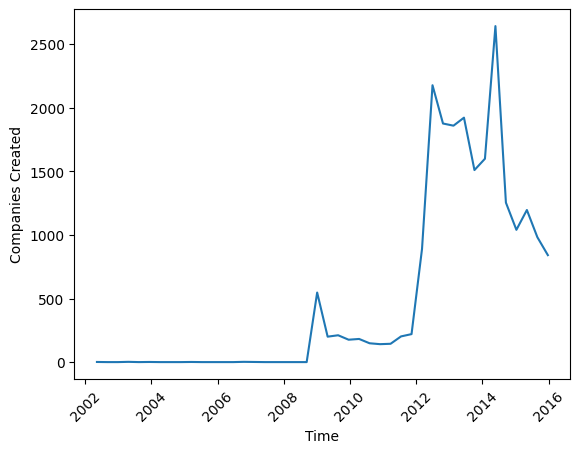

In [14]:
sns.set_context()
ax = plt.gca()
plt.xticks(rotation=45)
ax.set_xlabel("Time")
ax.set_ylabel("Companies Created")
sns.lineplot(x = timestamps, y = edge_count,ax=ax)

### Using windows to filter particular timepoints of interest

As seen in the line plot, there is a spike at year 2014. To investigate this further we look at a window of 01-01-2014 to 01-01-2015.

<Axes: xlabel='Time', ylabel='Companies Created'>

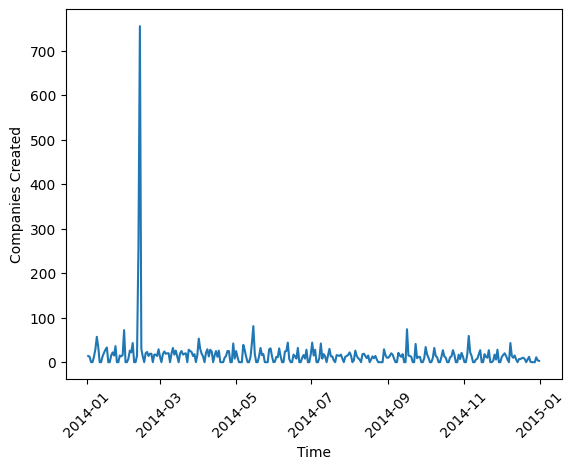

In [15]:
filtered_view = g.window('2014-01-01', '2015-01-01')
filtered_views = filtered_view.rolling(100000000)
timestamps   = []
edge_count   = []

for filtered_view in filtered_views:
    time = filtered_view.latest_date_time()
    timestamps.append(time)
    edge_count.append(filtered_view.num_edges())            

sns.set_context()
ax = plt.gca()
plt.xticks(rotation=45)
ax.set_xlabel("Time")
ax.set_ylabel("Companies Created")
sns.lineplot(x = timestamps, y = edge_count,ax=ax)

There seems to be a spike between 2014-02-01 to 2014-02-15. We create a window for this spike to investigate further.

<Axes: xlabel='Time', ylabel='Companies Created'>

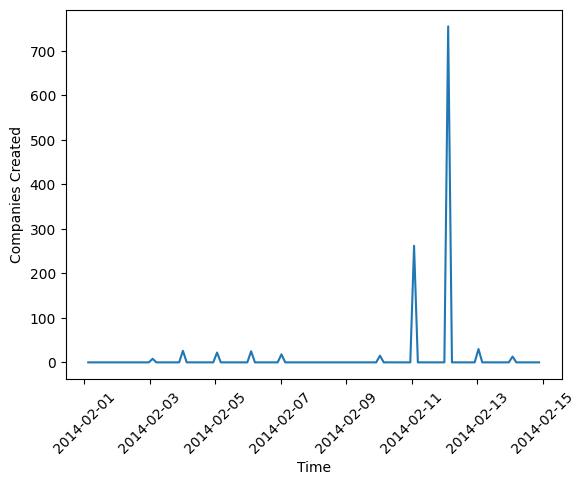

In [16]:
filtered_view2 = g.window('2014-02-01', '2014-02-15')
filtered_views2 = filtered_view2.rolling(window=10000000) 
timestamps   = []
edge_count   = []

for filtered_view2 in filtered_views2:
    time = filtered_view2.latest_date_time()
    timestamps.append(time)
    edge_count.append(filtered_view2.num_edges())            

sns.set_context()
ax = plt.gca()
plt.xticks(rotation=45)
ax.set_xlabel("Time")
ax.set_ylabel("Companies Created")
sns.lineplot(x = timestamps, y = edge_count,ax=ax)

There seems to be a spike on 2014-02-12. We investigate this further by creating a window that only includes this date and create a new graph where companies are only added if the director has stayed at that company longer than a year.

In [17]:
sus_companies = []
twelfth_of_feb = g.at('2014-02-12')
for edge in twelfth_of_feb.vertex('Barbara KAHAN').edges():
    if (edge.property("epoch_resigned") - edge.earliest_time()) > 157784630000:
       sus_companies.append(edge)
g2 = Graph()
for edge in sus_companies:
    g2.add_edge(1, edge.src().name(), edge.dst().name())
print(sus_companies.__len__())

311


### Dynamic visualisation of your graph in Raphtory

To visualise in Raphtory, we use Raphtory's `.to_pyvis()` function to create a dynamic visualisation of the edges. In this way, we can see the companies involved on 2014-02-12, and the companies where the director has stayed longer than a year at.

The visualisation will appear in a file called `nx.html` which can be opened in a web browser.

In [ ]:
vis.to_pyvis(graph=g2, edge_color='#F6E1D3',shape="image")  

If you would like your graph in a list of vertices and edges, you can call methods such as `vertices()` and `edges()`.

In [ ]:
twelfth_of_feb.vertices()

In [ ]:
twelfth_of_feb.edges()